In [1]:
# Includes Librarires
import lhapdf
import math
import numpy as np
from random import sample

In [26]:
# Build PDF input samples
def build_pdf(params, x_grid):
    if params['nb_replicas'] < 1:
        raise ValueError("Number of input replicas must be greater or equal to 1")
    else:
        input_size = params['nb_replicas']

    pdf_name = params["pdf_set_name"]
    flavors  = params['flavors']
    q2_scale = params['Q2_scale']

    """
    At the moment, the shape of the input pdf replicas (which gets fed to the
    network) is (nb_replicas, flavor, x_grid). This is due to the fact that,
    at the end, the generator has to generate as many replicas as one wants
    (meaning that the number of replicas has to be in the first argument).

    """
    # If only a single input replicas is given
    if input_size == 1:
        # Pick the Central Value
        pdf = [lhapdf.mkPDF(pdf_name, 0)]
    else:
        pdf = sample(lhapdf.mkPDFs(pdf_name), input_size)

    # Data of Shape (pdf_replicas, flavors, x_grid)
    data = []
    for p in pdf:
        x_space = []
        for x in x_grid:
            x_space.append(p.xfxQ2(flavors,x,q2_scale))
        data.append(x_space)
    return np.array(data)

In [27]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.font_manager import FontProperties

In [28]:
# Plot the Result
def plot_input_replicas(data, x_grid):
    plt.figure(figsize=[9,6])
    for pdf in data:
        plt.plot(x_grid, pdf, color='red', alpha=0.45)
    plt.xlabel('x')
    plt.ylabel('xfx')
    plt.grid(True)
    plt.xlim([0,1])
    plt.ylim([-2e-1,6e-1])
    plt.title('Input_replicas')
    # plt.savefig("input_replicas_flavors.png")
    plt.show()
    plt.close()

In [29]:
# Set Physical Scales
input_params = {'pdf_set_name': "NNPDF31_nnlo_as_0118_1000", 
                'flavors': 1,
                'Q2_scale': 1.7, 
                'nb_replicas': 100}
                
# Toy x_grid
x = np.logspace(math.log(1e-5), math.log(1), num=100, base=math.exp(1))

In [30]:
%time input_pdf = build_pdf(input_params, x)
input_pdf.shape

CPU times: user 10.9 s, sys: 605 ms, total: 11.5 s
Wall time: 11.5 s


(100, 100)

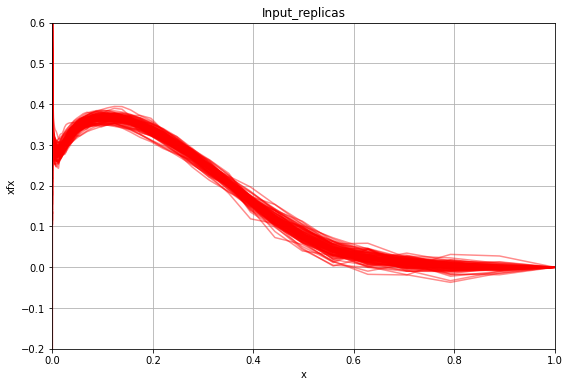

In [31]:
plot_input_replicas(input_pdf, x)

### Test of different GAN Models (as implemented in *src*) for simple Input

In [32]:
# Include libraries for Keras & Tensorflow
import os, sys
# Silent tf for the time being
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as  tf
import keras.backend as K
from keras import Model
from keras.models import Sequential
from keras.layers import Layer
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras import initializers
from keras.layers import Activation
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import Adadelta
from keras.layers.advanced_activations import ELU
from keras.layers.advanced_activations import ReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal

Using TensorFlow backend.


In [34]:
# Layer derived class for preprocessing
class preprocessing_fit(Layer):
    """
    Multiply the previous layer by:
            x^a (1-x)^b
    """

    def __init__(self, xval, trainable=True, kernel_initializer='ones', **kwargs):
        self.xval = xval
        self.trainable = trainable
        self.kernel_initializer = initializers.get(kernel_initializer)
        super(preprocessing_fit, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', shape=(2,),
                initializer=self.kernel_initializer,
                trainable=self.trainable)
        super(preprocessing_fit, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape

    def call(self, pdf):
        xres = self.xval**self.kernel[0] * (1-self.xval)**self.kernel[1]
        return pdf*xres

# Custom layer that contains the information on x_grid
class xlayer(Layer):

    """
    Custom array that inputs the information on the x-grid.
    """

    def __init__(self, output_dim, xval, kernel_initializer='glorot_uniform', **kwargs):
        self.output_dim = output_dim
        self.xval = K.constant(xval)
        self.kernel_initializer = initializers.get(kernel_initializer)
        super(xlayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', shape=(K.int_shape(self.xval)[0],
                input_shape[1], self.output_dim), initializer=self.kernel_initializer,
                trainable=True)
        super(xlayer, self).build(input_shape)

    def call(self, x):
        # xres outputs (None, input_shape[1], len(x_pdf))
        xres = tf.tensordot(x, self.xval, axes=0)
        # xfin outputs (None, output_dim)
        xfin = tf.tensordot(xres, self.kernel, axes=([1,2],[0,1]))
        return xfin

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [35]:
# Define Model for Discriminator
def discriminator(params, output_size):
    # Weights initialization
    init  = RandomNormal(stddev=0.02)
    # Weights constraint
    const = None
    # Activation per layer
    d_activ = params['d_activ']
    d_nodes = params['d_nodes']

    ## Critic Architecture ##
    D_input = Input(shape=(output_size,))

    # 1st hidden dense layer
    D_1l = Dense(d_nodes, kernel_initializer=init, kernel_constraint=const)(D_input)
    D_1a = d_activ(D_1l)
    # 2nd hidden dense layer
    D_2l = Dense(d_nodes//2, kernel_initializer=init, kernel_constraint=const)(D_1a)
    D_2a = d_activ(D_2l)

    # Output 1 dimensional probability
    D_output = Dense(1, activation='sigmoid')(D_2a)

    model = Model(D_input, D_output)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.0002, beta_1=0.5),
                  metrics=['accuracy'])

    return model

# Define Model for Generator
def generator(params, output_size):
    # Weights initialization
    init  = RandomNormal(stddev=0.02)
    # Activation per layer
    g_activ = params['g_activ']
    # noise size and nodes dim
    g_nodes     = params['g_nodes']
    noise_size  = params['noise_size']

    ## Generator Architecture ##
    # Input of G/Random noise of 1 dim vector
    G_input = Input(shape=(noise_size,))

    # 1st hidden dense layer
    G_1l = Dense(g_nodes//4, kernel_initializer=init)(G_input)
    G_1a = g_activ(G_1l)
    if params['x_multiply']:
        G_2l = xlayer(g_nodes//2, params['x_grid'], kernel_initializer=init)(G_1a)
    else:
        G_2l = Dense(g_nodes//2, kernel_initializer=init)(G_1a)
    G_2a = g_activ(G_2l)
    G_3l = Dense(g_nodes, kernel_initializer=init)(G_2a)
    G_3a = g_activ(G_3l)
    # G_4l = Dense(g_nodes*2, kernel_initializer=init)(G_3a)
    # G_4a = g_activ(G_4l)
    G_5l = Dense(output_size, activation='tanh', kernel_initializer=init)(G_3a)

    # Output from the generator
    G_output = G_5l
    if params['preprocessing']:
        G_output = preprocessing_fit(params['x_grid'])(G_5l)

    model = Model(G_input, G_output)

    return model 

In [36]:
# Define Adversarial Model
def adversarial(generator, discriminator):
    # make weights in the discriminator not trainable
    # discriminator.trainable = False

    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.0002, beta_1=0.5))

    return model

In [37]:
model_params = {'g_nodes': 128, 'g_activ': LeakyReLU(0.2), 'noise_size': 100,
                'd_nodes': 128, 'd_activ': LeakyReLU(0.2),
                'x_multiply': False, 'preprocessing': False, 'x_grid': x}

In [38]:
# Sample input replicas
def sample_input_replicas(data, batch_size):
    """ This is a bit trickier as one wants to batch only a subset
    of the input replicas while the input data has the following
    shape (nb_flavors, nb_replicas, x_grid)"""

    index_replicas = np.random.randint(0, data.shape[0], batch_size)
    pdf_batch = data[index_replicas]
    # Create labels of ones for reals
    y_real = np.ones(batch_size)
    return pdf_batch, y_real

# generate points in latent space as input for the generator
def latent_space(batch_size, noise_size):
    # generate points in the latent space
    noise_latent = np.random.randn(noise_size * batch_size)
    # reshape into a batch of inputs for the network
    return noise_latent.reshape(batch_size, noise_size)

# Sample output fake replicas
def generate_fake_replicas(generator, batch_size, noise_size):
    # Feed noise to the generator
    noise    = latent_space(batch_size, noise_size)
    pdf_fake = generator.predict(noise)
    # Create labels of 0 for fake samples
    y_fake   = np.zeros(batch_size)
    return pdf_fake, y_fake

# Sample noise that will enter in the Adv. GAN
def sample_input_noise(batch_size, noise_size):
    noise = latent_space(batch_size, noise_size)
    # Create labels of ones
    y_gen = np.ones(batch_size)
    return noise, y_gen

# Summarizes performance
def summarize_performance(dataset, g_model, d_model, n_samples=75):
    # prepare real samples
    X_real, y_real = sample_input_replicas(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_replicas(g_model, n_samples, 100)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [39]:
# Define plot function to summarize the performance
def plot_generated_pdf(discriminator, generator, data,
                       batch_size, x_grid, noise_size, kth):
    path = os.getcwd()
    # Create folder
    if not os.path.exists('%s/iterations' % path):
        try:
            original_umask = os.umask(000)
            os.makedirs('%s/iterations' % path, 0o777)
        finally:
            os.umask(original_umask)
    else:
        pass
    
    # Prepare real samples
    x_real, y_real = sample_input_replicas(data, batch_size)
    # Evaluate discriminator on real samples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # Prepare fake samples
    x_fake, y_fake = generate_fake_replicas(generator, batch_size, noise_size)
    # Evaluate discriminator on fake samples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

    plt.figure(figsize=[9,6])
    for real, fake in zip(x_real, x_fake):
        plt.plot(x_grid, real, color='red', label='real', alpha=0.45)
        plt.plot(x_grid, fake, color='blue', label='fake', alpha=0.45)
    plt.xlabel('x')
    plt.ylabel('xfx')
    plt.grid(True)
    plt.xlim([0,1])
    plt.ylim([-2e-1,2])
    plt.title('real_vs_fake_replicas')
    plt.savefig("%s/iterations/plot_at_iteration_%d.png" %(path, kth))
    plt.close()

In [46]:
# Train the Model
def train_gan(disc_model, gen_model, adv_model, x_grid,
              data, noise, nb_epochs=100, batch_size=1):
    # Batches per epoch
    batch_per_epoch = int(data.shape[1]/batch_size)
    # Training per iteration
    nb_steps = batch_per_epoch * nb_epochs
    # Compute half-batch
    if batch_size < 2:
        half_batch_size = 1
    else:
        half_batch_size = int(batch_size/2)

    # Training iterations
    for tr in range(1, nb_steps+1):

        # Train the discriminator for a certain steps
        disc_model.trainable = True
        for _ in range(1):
            # Train on real samples
            x_real, y_real = sample_input_replicas(data, half_batch_size)
            r_dloss, r_dacc = disc_model.train_on_batch(x_real, y_real)
            # Train on fake samples
            x_fake, y_fake = generate_fake_replicas(gen_model, half_batch_size, noise)
            f_dloss, f_dacc = disc_model.train_on_batch(x_fake, y_fake)

        disc_model.trainable = False
        # Train the Adversarial GAN for a certain setps
        for _ in range(1):
            # Generate latent point for the generator
            inp_noise, y_gen = sample_input_noise(batch_size, noise)
            gan_loss = adv_model.train_on_batch(inp_noise, y_gen)
        
        # Logoutput
        if tr % 200 == 0:
            print("Iter:{} out of {}. disc_loss: {:6f}. gan_loss: {:6f}"
                   .format(tr, nb_steps+1, r_dloss+f_dloss, gan_loss))
            # Summarizes peformance
            summarize_performance(data, gen_model, disc_model, n_samples=75)
            # Generates Plot
            plot_generated_pdf(disc_model, gen_model, data, batch_size, x_grid, noise, tr)

In [47]:
# Define output size
output_size = x.shape[0]

In [48]:
# Disc
disc_model = discriminator(model_params, output_size)
disc_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          12928       input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       multiple             0           dense_8[0][0]                    
                                                                 dense_9[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 64)           8256        leaky_re_lu_2[2][0]        

In [49]:
# Gen
gen_model = generator(model_params, output_size)
gen_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 32)           3232        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       multiple             0           dense_11[0][0]                   
                                                                 dense_12[0][0]                   
                                                                 dense_13[0][0]                   
____________________________________________________________________________________________

In [50]:
# Adversarial
gan_model = adversarial(gen_model, disc_model)
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 100)               26564     
_________________________________________________________________
model_3 (Model)              (None, 1)                 21249     
Total params: 47,813
Trainable params: 47,813
Non-trainable params: 0
_________________________________________________________________


In [54]:
train_gan(disc_model,
          gen_model,
          gan_model,
          x,
          input_pdf,
          model_params['noise_size'],
          nb_epochs=1000,
          batch_size=20
         )

Iter:200 out of 5001. disc_loss: 1.910066. gan_loss: 0.253223
>Accuracy real: 100%, fake: 0%


/home/tanjona/.local/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(


Iter:400 out of 5001. disc_loss: 1.905816. gan_loss: 0.265508
>Accuracy real: 100%, fake: 0%


/home/tanjona/.local/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(


Iter:600 out of 5001. disc_loss: 1.945344. gan_loss: 0.273585
>Accuracy real: 100%, fake: 0%


/home/tanjona/.local/lib/python3.8/site-packages/keras/engine/training.py:296: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  warnings.warn(UserWarning(


KeyboardInterrupt: 

## ERF Checks

In [ ]:
import sys
sys.path.append('../src/wganpdfs')
from custom import normalizationK
from custom import smm
from numba import jit, njit
import time

In [ ]:
test_params  = {'pdf_set_name': "NNPDF30_nnlo_as_0118", 
                'flavors': 1,
                'Q2_scale': 1.7, 
                'nb_replicas': 50}

In [ ]:
# nnpdf30 = build_pdf(test_params, x)
# nnpdf31 = build_pdf(input_params, x)

In [ ]:
nnpdf30 = np.load('nnpdf30.npy')
nnpdf31 = np.load('nnpdf31.npy')

In [ ]:
test_cfd68 = normalizationK(nnpdf31, nnpdf30, 1000)
# Take randomized sets from the true
rd_nnpdf30 = test_cfd68.random_replicas(40)

In [ ]:
tr, fk = test_cfd68.cfd68('mean', rd_nnpdf30)

In [ ]:
%time test_cfd68.Nk_mean()

In [ ]:
estimators = {'estimators': ['mean', 'stdev']}

In [ ]:
smetric = smm(nnpdf30, nnpdf31, estimators)

In [ ]:
%time smetric.ERF()

## Check Numba

In [ ]:
from scipy import stats
import math